In [ ]:
!pip install bertopic

In [ ]:
!pip install -U sentence-transformers

## Lyrics dataset:

In [ ]:
import pandas as pd

df = pd.read_csv('lyrics-dataset-v2.csv')
df.head()

,lyrics,genre,year,number_of_words,number_of_unique_words
0,we got butter aiyo one thing for sure keep you...,hiphop,NaN,574,257
1,aye it's sean paul 'long side the mandem calle...,pop,NaN,457,160
2,beauty finds refuge in herself lovers wrapped ...,indie,NaN,129,74
3,you've changed your tune many times since we'v...,rock,NaN,309,111
4,i got all these j's rolled up and got all thes...,hiphop,NaN,517,149


In [ ]:
lyrics = df['lyrics'].dropna()
len(lyrics)

63797

Pre-processing - required? For previous dataset - I tried to remove entries with guitar riffs and tabs.

In [ ]:
lyrics = list(lyrics)

In [ ]:
import re

PERMITTED_CHARS = " .,'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_" 

def preprocess(text_entries):
  new_text_entries = []
  for text in text_entries:
    text = "".join(c for c in text if c in PERMITTED_CHARS)
    new_text_entries.append(text)
  return new_text_entries

In [ ]:
lyrics = preprocess(lyrics)

## Bag of Words dataset - TCC

In [ ]:
import numpy as np

In [ ]:
import pandas as pd

df = pd.read_csv('tcc_ceds_music.csv')
lyrics = df['lyrics']
lyrics = list(lyrics)

In [ ]:
len(lyrics)

28372

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')
#vectorizer_model = CountVectorizer(ngram_range=(1, 1), stop_words="english")

topic_model = BERTopic(language='english', embedding_model=sentence_transformer, calculate_probabilities=True, verbose=True)

In [ ]:
topics, probs = topic_model.fit_transform(lyrics)

Batches:   0%|          | 0/1994 [00:00<?, ?it/s]

2022-04-07 23:20:26,070 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-04-07 23:22:02,593 - BERTopic - Reduced dimensionality with UMAP
2022-04-07 23:22:16,687 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name
0,0,46229,0_you_the_to_and
1,1,17118,1_like_know_time_come
2,2,289,2_christmas_santa_the_and
3,3,55,3_riff_gtr_intro_the
4,4,39,4_christmas_sleigh_bell_snow
5,-1,38,-1_christmas_and_going_on
6,5,18,5_wonderland_winter_snowman_walk
7,6,11,6_lucienne_alves_enviado_por


In [ ]:
topic_model.visualize_topics()

In [ ]:
def get_similar_topics(concept):
  topic_indices = topic_model.find_topics(concept)[0]
  topics = np.array([topic_model.topics[t] for t in topic_indices], dtype=object)[..., 0]
  print(topics)

In [ ]:
get_similar_topics("get free")

[['lifetime' 'frighten' 'free' 'realign' 'mind' 'carefree' 'life'
  'demons' 'twentyfive' 'sincerely']
 ['money' 'cash' 'dollar' 'pay' 'rely' 'lock' 'work' 'lotto' 'million'
  'swingin']
 ['days' 'dream' 'island' 'american' 'canaan' 'live' 'remove' 'cost'
  'guy' 'croix']
 ['struggle' 'bless' 'life' 'speak' 'simple' 'live' 'happiness'
  'positive' 'let' 'babylon']
 ['doubtful' 'melt' 'cold' 'enemies' 'ways' 'count' 'free' 'trust'
  'memory' 'unkind']]


In [ ]:
topic_model.save("topic_model")

In [ ]:
tm = BERTopic.load("topic_model")

## Evaluation Pipeline

Import pre-trained word embeddings

In [ ]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
import statistics

### 1. Topic Coherence

In [ ]:
def topic_coherence(index):
  """
  Input: index of a topic 
  Output: coherence score
  """
  topic_words = [word for (word, _) in topic_model.topics[index]]
  similarities = [wv.similarity(w1, w2) for w1 in topic_words for w2 in topic_words 
                  if w1 != w2 if w1 in wv.vocab and w2 in wv.vocab]
  return statistics.mean(similarities)

In [ ]:
def overall_topic_coherence():
  tc_scores = [topic_coherence(topic) for topic in topic_model.topics]
  print("Minimum  topic coherence: {}".format(min(tc_scores)))
  print("Maximum  topic coherence: {}".format(max(tc_scores)))
  print("Mean  topic coherence: {}".format(statistics.mean(tc_scores)))
  print("Median  topic coherence: {}".format(statistics.median(tc_scores)))

In [ ]:
overall_topic_coherence()

Minimum  topic coherence: 0.14861039817333221
Maximum  topic coherence: 0.34672191739082336
Mean  topic coherence: 0.20212408900260925
Median  topic coherence: 0.17527377605438232


###2. Topic Diversity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def topic_pairwise_similarity(index1, index2):
  """
  Input: indexes of 2 distinct topics
  Output: dissimilarity score
  """
  topic_words1 = [word for (word, _) in topic_model.topics[index1]][:5]
  topic_words2 = [word for (word, _) in topic_model.topics[index2]][:5]

  similarities = [wv.similarity(w1, w2) for w1 in topic_words1 for w2 in topic_words2 
                  if w1 in wv.vocab and w2 in wv.vocab]
  """
  median_vector1 = sum([wv[w] for w in topic_words1 if w in wv.vocab])
  median_vector2 = sum([wv[w] for w in topic_words2 if w in wv.vocab])
  
  return cosine_similarity([median_vector1], [median_vector2])
  """
  return 1 - statistics.mean(similarities)


In [ ]:
def topic_diversity():
  td_scores = [topic_pairwise_similarity(t1, t2) for t1 in topic_model.topics for t2 in topic_model.topics if t1 != t2]
  print("Minimum  topic diversity: {}".format(min(td_scores)))
  print("Maximum  topic diversity: {}".format(max(td_scores)))
  print("Mean  topic diversity: {}".format(statistics.mean(td_scores)))
  print("Median  topic diversity: {}".format(statistics.median(td_scores)))

In [ ]:
topic_diversity()

Minimum  topic diversity: 0.6551565527915955
Maximum  topic diversity: 0.9394026473164558
Mean  topic diversity: 0.8336030699844871
Median  topic diversity: 0.8601964488625526


In [ ]:
number_of_topics = len(topic_model.topics)

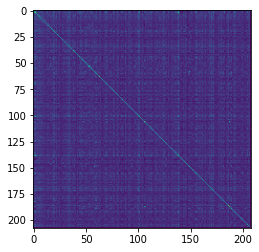

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

pairwise_similarities = np.zeros((number_of_topics, number_of_topics))
for idx1 in range(number_of_topics-1):
  for idx2 in range(number_of_topics-1):
    pairwise_similarities[idx1][idx2] = topic_pairwise_similarity(idx1, idx2)

plt.imshow(pairwise_similarities)
plt.show()

## Predicting topics and evaluating the quality of predictions

In [ ]:
test_lyric = lyrics[50001:]
test_lyric
topics, probs = topic_model.transform(test_lyric)

Batches:   0%|          | 0/432 [00:00<?, ?it/s]

2022-04-05 19:42:33,170 - BERTopic - Reduced dimensionality with UMAP
2022-04-05 19:42:33,886 - BERTopic - Predicted clusters with HDBSCAN
2022-04-05 19:42:36,110 - BERTopic - Calculated probabilities with HDBSCAN


## Study: Topic variation of songs in user-generated playlists

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
playlist_folder = "gdrive/Othercomputers/My Laptop/Fur-Stefi"

In [ ]:
f = open("playlist_findings2.txt", "a")

In [ ]:
import os

for playlist_file in sorted(os.listdir(playlist_folder)):
  df = pd.read_csv(os.path.join(playlist_folder, playlist_file))
  name = df['name'][1]
  print(name)
  lyrics = list(df['lyrics'])
  topics, _ = topic_model.transform(lyrics)
  #f.write("Name of playlist: {}\n".format(name))
  real_topics = [t for t in topics if t != -1]
  #f.write("Predicted topics: {}\n".format(real_topics))
  
  #title_topics, _ = topic_model.find_topics(name)
  #f.write("Title recommended topics: {}\n".format(title_topics))
  

In [ ]:
f.close()

In [ ]:
topic_model.topics[16]

[('christmas', 0.23591302466921063),
 ('santa', 0.10189912026081312),
 ('jingle', 0.0658394210953644),
 ('bell', 0.04534801780369108),
 ('year', 0.03846987383597328),
 ('carol', 0.03439174290958607),
 ('holiday', 0.03208911052718995),
 ('snow', 0.03075014733370269),
 ('mistletoe', 0.025053200715348098),
 ('dong', 0.023065860961046413)]

In [ ]:
!gdown --id 1FIDxukfkyFYj3dW7ktp1WXQSRh2KwiuZ 
!gdown --id 1vWPGrto3s4OI1_7mc-OLCZJGLI-6qI1P 
!gdown --id 1QaKoVSv8fQsjtfzZD1AyzaZKHEWh44tK 
!gdown --id 18J-7Kgwzg11CACZPPoEyiUERjNs9u48_

Downloading...
From: https://drive.google.com/uc?id=1FIDxukfkyFYj3dW7ktp1WXQSRh2KwiuZ
To: /content/playlist-52.csv
100% 197k/197k [00:00<00:00, 83.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vWPGrto3s4OI1_7mc-OLCZJGLI-6qI1P
To: /content/playlist-65.csv
100% 1.02M/1.02M [00:00<00:00, 170MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QaKoVSv8fQsjtfzZD1AyzaZKHEWh44tK
To: /content/playlist-72.csv
100% 343k/343k [00:00<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=18J-7Kgwzg11CACZPPoEyiUERjNs9u48_
To: /content/playlist-84.csv
100% 178k/178k [00:00<00:00, 105MB/s]


In [ ]:
from collections import Counter

In [ ]:
sensitive_topics = [0, 1, 2]

In [ ]:
def describe_playlist(path_to_playlist):
  df = pd.read_csv(path_to_playlist)
  name = df['name'][1]
  print(name)
  lyrics = list(df['lyrics'])
  topics, _ = topic_model.transform(lyrics)
  print("Name of playlist: {}\n".format(name))
  real_topics = [t for t in topics if t != -1]

  counter = Counter(real_topics)
  for key in counter:
    print("Number of times topic {} appears: {}".format(key, counter[key]))
    if key in sensitive_topics:
      print("[Sensitive language: topic was hidden]\n")
    else:
      topic_words = np.array(topic_model.topics[key], dtype=object)[..., 0]
      print(topic_words)

In [ ]:
describe_playlist("playlist-72.csv")

spanish jams


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

2022-04-07 11:22:02,979 - BERTopic - Reduced dimensionality with UMAP
2022-04-07 11:22:03,010 - BERTopic - Predicted clusters with HDBSCAN
2022-04-07 11:22:03,364 - BERTopic - Calculated probabilities with HDBSCAN


Name of playlist: spanish jams

Number of times topic 0 appears: 5
[Sensitive language: topic was hidden]

Number of times topic 106 appears: 1
['reggae' 'music' 'trust' 'root' 'whiny' 'shaky' 'dancehall' 'rastaman'
 'raggae' 'play']
Number of times topic 103 appears: 1
['darling' 'carry' 'dearest' 'shoo' 'sweetheart' 'stay' 'apart' 'pretty'
 'amour' 'tender']
